In [13]:
# First, load the IPython extension for auto-reloading
%load_ext autoreload
%autoreload 2

import pickle
import torch
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from src.eval.evaluate_model import (
    evaluate_model,
    evaluate_by_hydrophone,
    evaluate_by_anomaly_type,
    plot_confusion_matrix,
    plot_example_spectrograms,
    plot_threshold_f1f2_curve,
    plot_all_false_positives,
    plot_all_false_negatives,
    plot_anomaly_type_metrics,
    plot_anomaly_type_by_hydrophone,
    plot_co_occurrence_matrix
)
from src.utilities.training_utils import create_model
from src.onc_dataset import ONCSpectrogramDataset
from src.models import AMBAModel
from torch.utils.data import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Path to your model directory
#model_dir = Path("/scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1")
model_dir = Path("/scratch/merileo/exp/finetune/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-full_dataset_hydrophones-noexclude")
checkpoint_path = str(model_dir / "models/ft-cls_best_checkpoint.pth")

# Load the saved args
with open(model_dir / "args.pkl", "rb") as f:
    args = pickle.load(f)

# Create and load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(args)
model = model.to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

model.load_state_dict(state_dict)

Vision Mamba Config: {'img_size': (512, 512), 'patch_size': 16, 'stride': 16, 'embed_dim': 768, 'depth': 24, 'channels': 1, 'num_classes': 2, 'drop_rate': 0.0, 'drop_path_rate': 0.1, 'norm_epsilon': 1e-05, 'rms_norm': False, 'residual_in_fp32': False, 'fused_add_norm': False, 'if_rope': False, 'if_rope_residual': False, 'bimamba_type': 'v2', 'if_cls_token': True, 'if_devide_out': True, 'use_double_cls_token': False, 'use_middle_cls_token': False, 'if_bidirectional': True, 'final_pool_type': 'none', 'if_abs_pos_embed': True, 'if_bimamba': False}
Loading pretrained model from: /scratch/merileo/exp/pretrain/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-full_dataset_hydrophones_FINAL/models/pretrain-joint_best_checkpoint.pth
Loaded state dict keys: dict_keys(['epoch', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_metrics', 'val_acc', 'args'])
Now loading SSL pretrained model from /scratch/merileo/exp/pretrain/amba-base-f16-t16-b16-lr1e-4-m300-cus

<All keys matched successfully>

In [3]:
# Load the test data
data_path = '/scratch/merileo/different_locations_incl_backgroundpipelinenormals_multilabel.h5'

# Create test dataset using the same args that were used during training
test_dataset = ONCSpectrogramDataset(
    data_path=data_path,  # or args.data_eval if you used a separate test set
    split='test',
    train_ratio=args.train_ratio,
    val_ratio=args.val_ratio,
    seed=args.split_seed if hasattr(args, 'split_seed') else 42,
    target_length=args.target_length,
    num_mel_bins=args.num_mel_bins,
    supervised=True,
    dataset_mean=args.dataset_mean,
    dataset_std=args.dataset_std,
    subsample_test=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=4
)


/home/merileo/ssamba/myenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Understanding F-beta, F1, and F2 Metrics

The **F-beta score** combines precision and recall, with $\beta$ weighting recall relative to precision:

$F_\beta = (1 + \beta^2) \times \frac{\text{Precision} \times \text{Recall}}{(\beta^2 \times \text{Precision}) + \text{Recall}}$

**F1 Score ($\beta = 1$):**

*   Harmonic mean of precision and recall, giving equal weight to both.
*   $F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
*   Useful for balanced precision and recall.

**F2 Score ($\beta = 2$):**

*   Weights recall more heavily than precision.
*   $F_2 = 5 \times \frac{\text{Precision} \times \text{Recall}}{(4 \times \text{Precision}) + \text{Recall}}$
*   Useful when minimizing false negatives (prioritizing recall) is important.

**Impact of Varying Classification Thresholds:**

As the classification threshold changes, precision and recall fluctuate, influencing F1 and F2 scores.

*   **F1 Score:** Reflects a balance, typically peaking where precision and recall are reasonably high.
*   **F2 Score:** More sensitive to recall changes. It may continue to rise with lower thresholds (higher recall, potentially lower precision) even as F1 declines, due to recall's greater weight.

Plotting these metrics against the threshold reveals the trade-offs and helps select a threshold aligning with specific error cost priorities.

/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


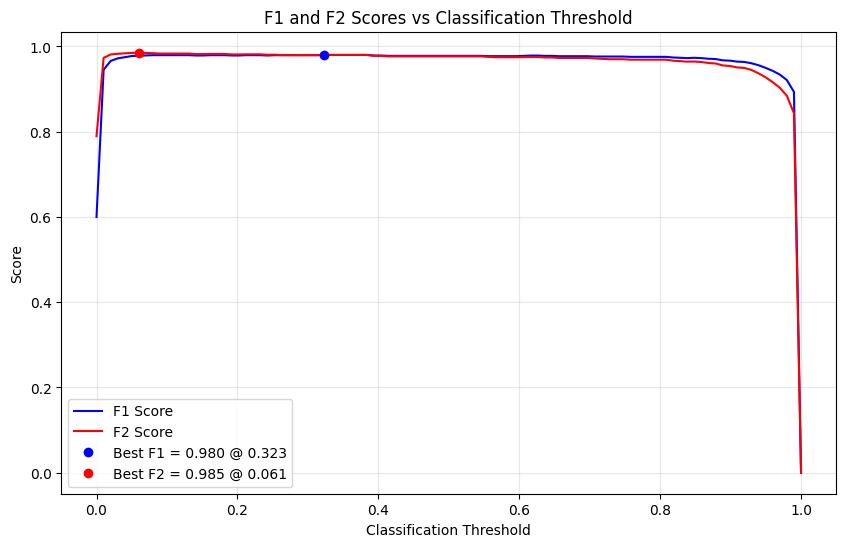

F1: Best score 0.980 at threshold 0.323
F2: Best score 0.985 at threshold 0.061


In [4]:
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=test_loader,
    device=device,
    task=args.task
)

print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")

In [5]:
# Get predictions and overall metrics
metrics, y_true, y_pred, sources = evaluate_model(model, test_loader, threshold=0.061)
print("Overall metrics:", metrics)

Overall metrics: {'accuracy': 0.9812121212121212, 'precision': 0.9668508287292817, 'recall': 0.9900990099009901, 'f1': 0.9783368273934312, 'f2': 0.9853603603603603, 'normal_acc': 0.9745493107104984, 'anomaly_acc': 0.9900990099009901}


In [6]:
# Get hydrophone-specific metrics
hydrophone_df = evaluate_by_hydrophone(y_true, y_pred, sources)
display(hydrophone_df)



hydrophone  samples  anomaly_rate  precision    recall  \
0               ICLISTENHF1252        3      1.000000   1.000000  1.000000   
1               ICLISTENHF1253      302      0.000000   0.000000  0.000000   
2               ICLISTENHF1266      254      0.149606   0.973684  0.973684   
3               ICLISTENHF1354      451      0.891353   0.959233  0.995025   
4               ICLISTENHF1951       92      0.358696   0.941176  0.969697   
5               ICLISTENHF6020       91      0.000000   0.000000  0.000000   
6               ICLISTENHF6093       63      0.000000   1.000000  0.000000   
7               ICLISTENHF6094       70      0.000000   0.000000  0.000000   
8               ICLISTENHF6095       93      1.000000   1.000000  1.000000   
9               ICLISTENHF6324      153      0.392157   1.000000  0.950000   
10     JASCOAMARHYDROPHONE2402       22      1.000000   1.000000  1.000000   
11  JASCOAMARHYDROPHONED001022       33      1.000000   1.000000  1.000000   
12  JASCOAMARHYDROPHONEE000186       23      1.000000   1.000000  1.000000   

          f1        f2  num_normal  num_anomaly  pred_normal  pred_anomaly  
0   1.000000  1.000000           0            3            0             3  
1   0.000000  0.000000         302            0          300             2  
2   0.973684  0.973684         216           38          216            38  
3   0.976801  0.987654          49          402           34           417  
4   0.955224  0.963855          59           33           58            34  
5   0.000000  0.000000          91            0           90             1  
6   0.000000  0.000000          63            0           63             0  
7   0.000000  0.000000          70            0           69             1  
8   1.000000  1.000000           0           93            0            93  
9   0.974359  0.959596          93           60           96            57  
10  1.000000  1.000000           0           22            0            22  
11  1.000000  1.000000           0           33            0            33  
12  1.000000  1.000000           0           23            0            23

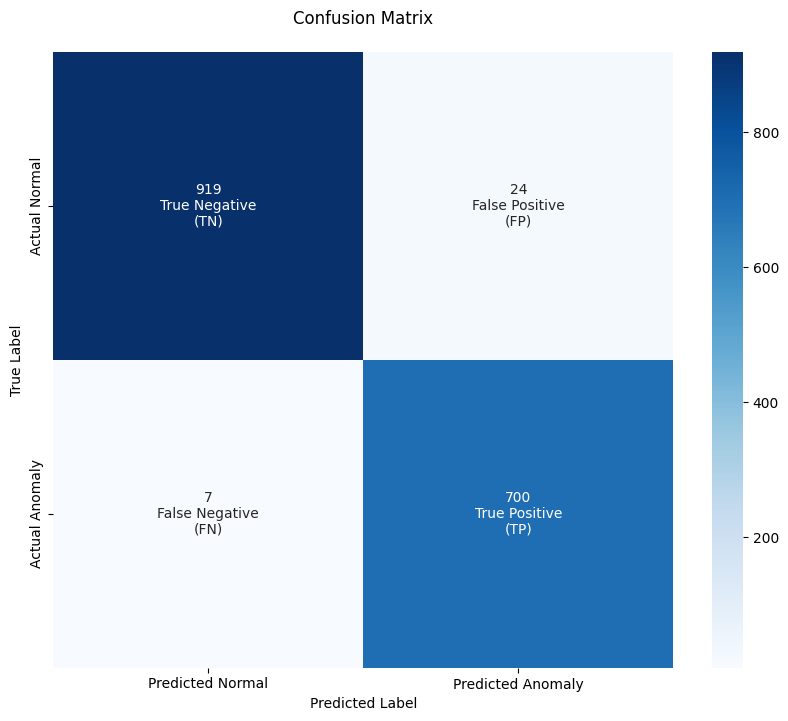

In [7]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)


Category sizes:
True Positives: 700
True Negatives: 919
False Positives: 24
False Negatives: 7


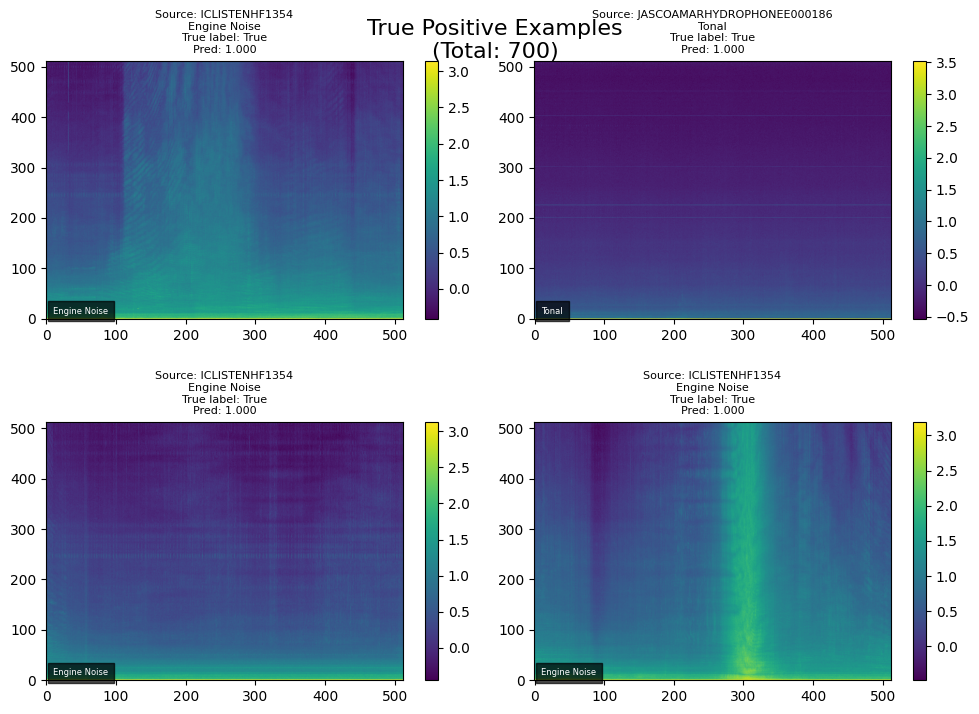

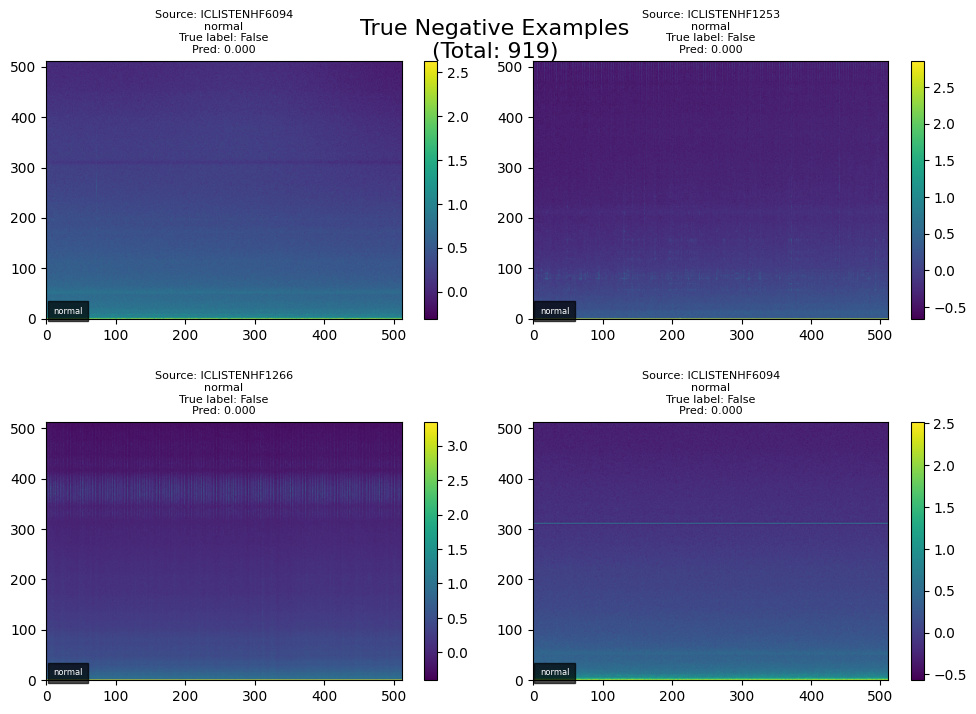

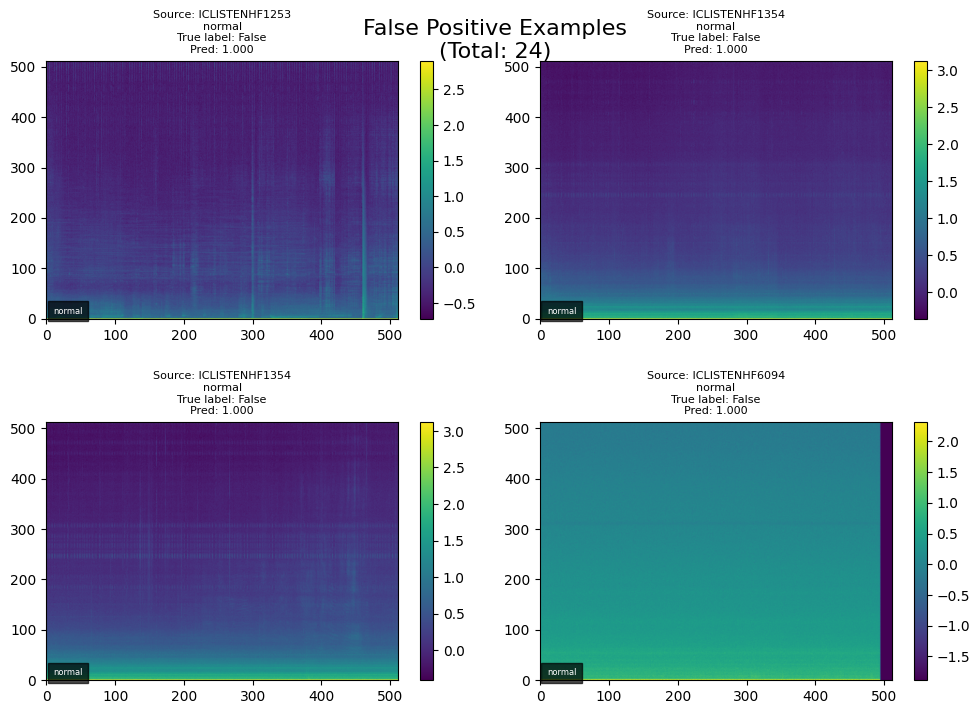

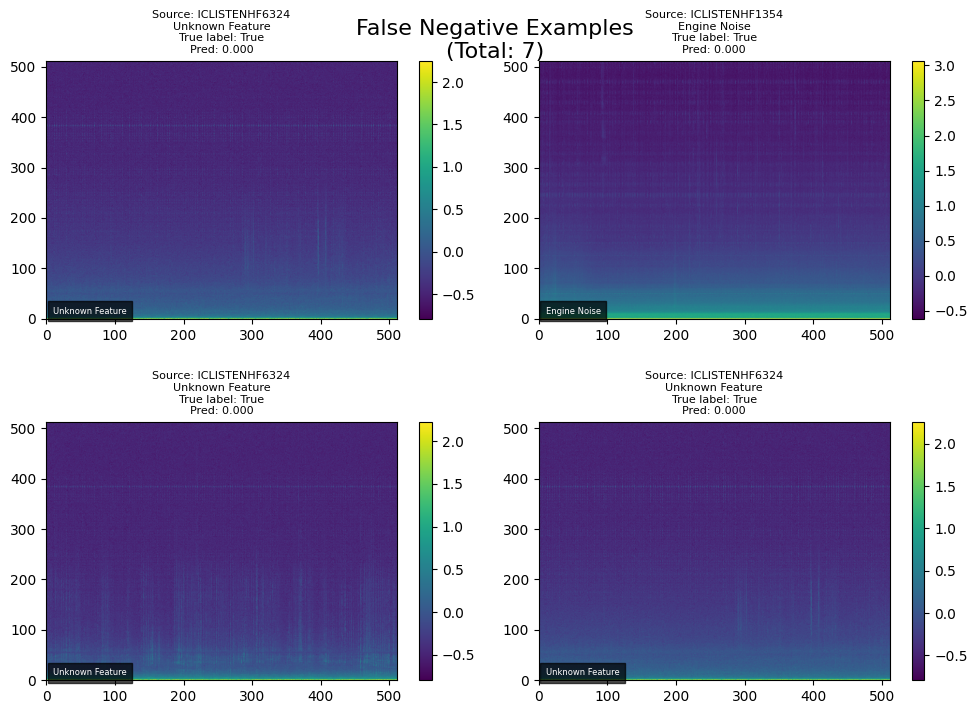

In [9]:
# Show example spectrograms
plot_example_spectrograms(test_dataset, y_pred, num_examples=4, samples_per_row=2)

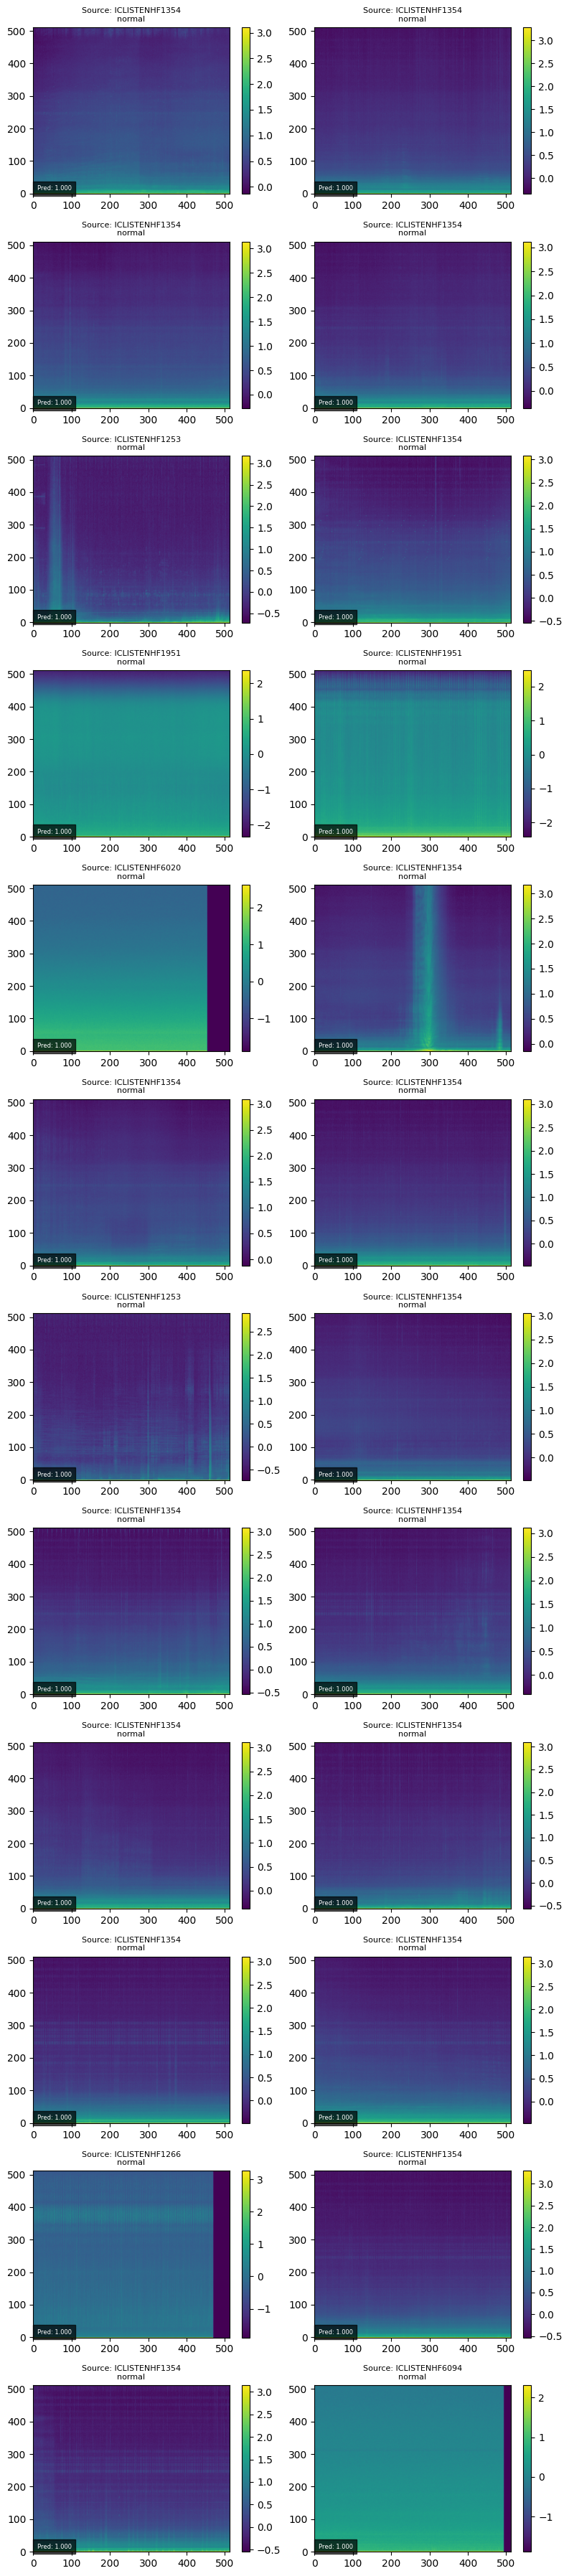

In [11]:
# To see all false positives
plot_all_false_positives(test_dataset, y_pred, samples_per_row=2)

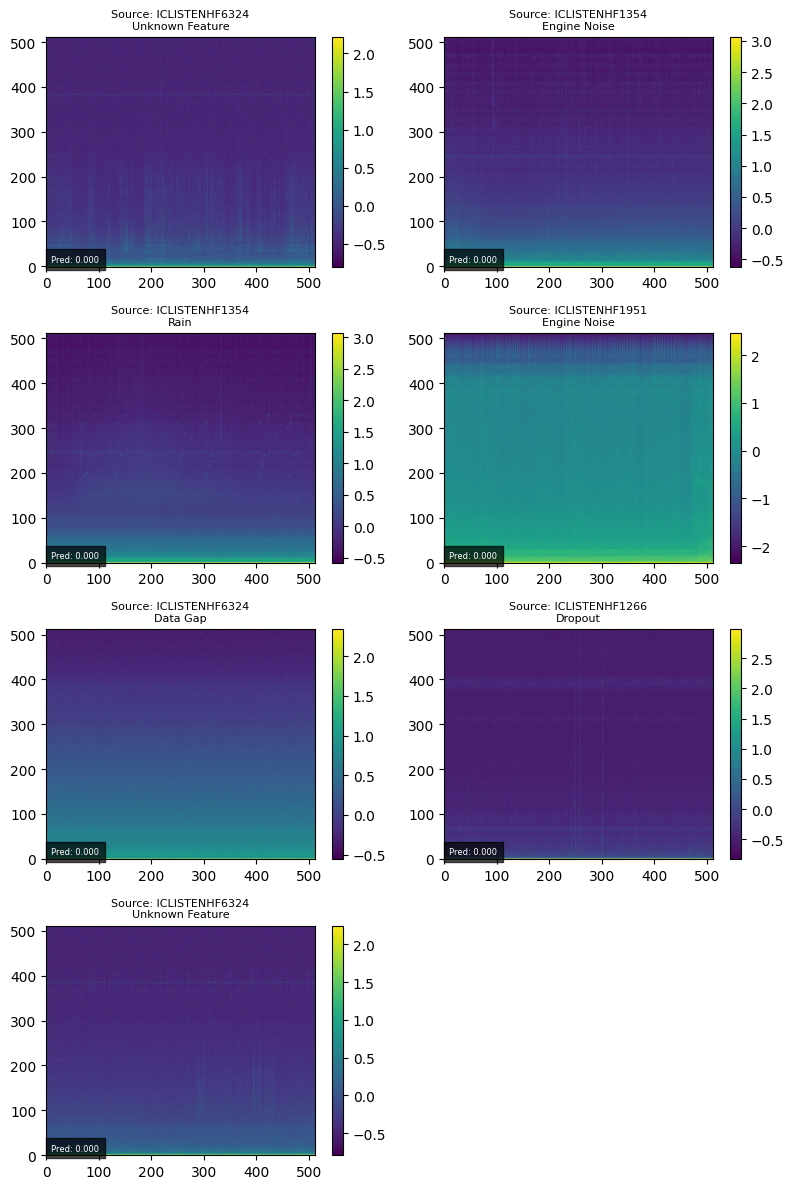

In [12]:
# To see all false negatives
plot_all_false_negatives(test_dataset, y_pred, samples_per_row=2)

In [7]:
anomaly_metrics, co_occurrence_metrics = evaluate_by_anomaly_type(test_dataset, y_pred)

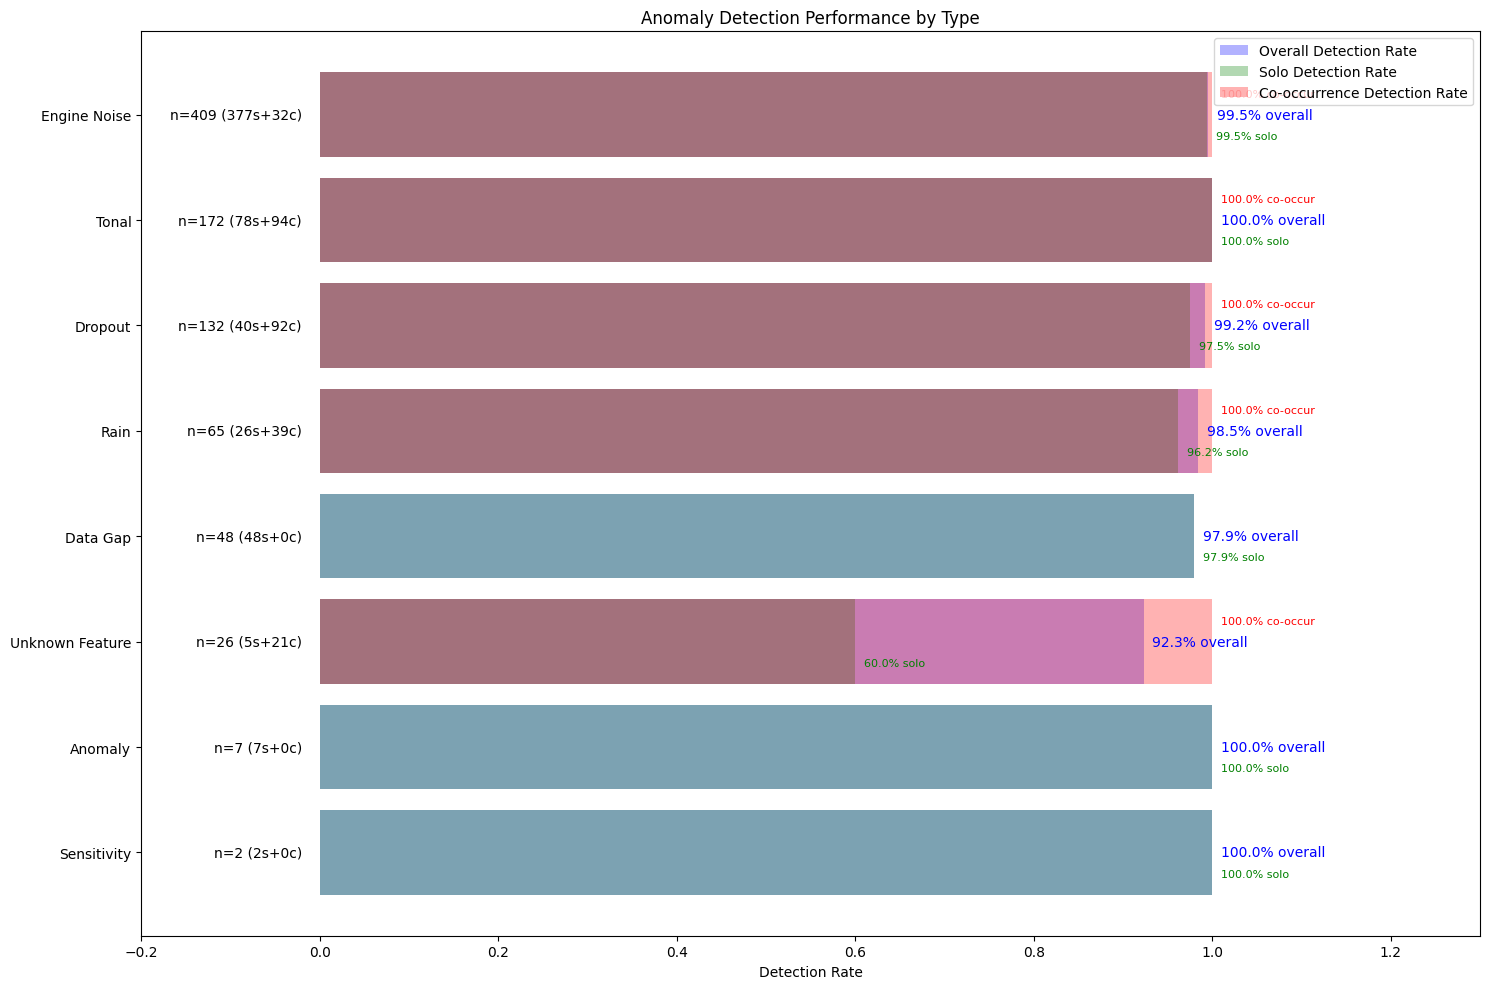

In [9]:
# Plot anomaly type metrics
plot_anomaly_type_metrics(anomaly_metrics)

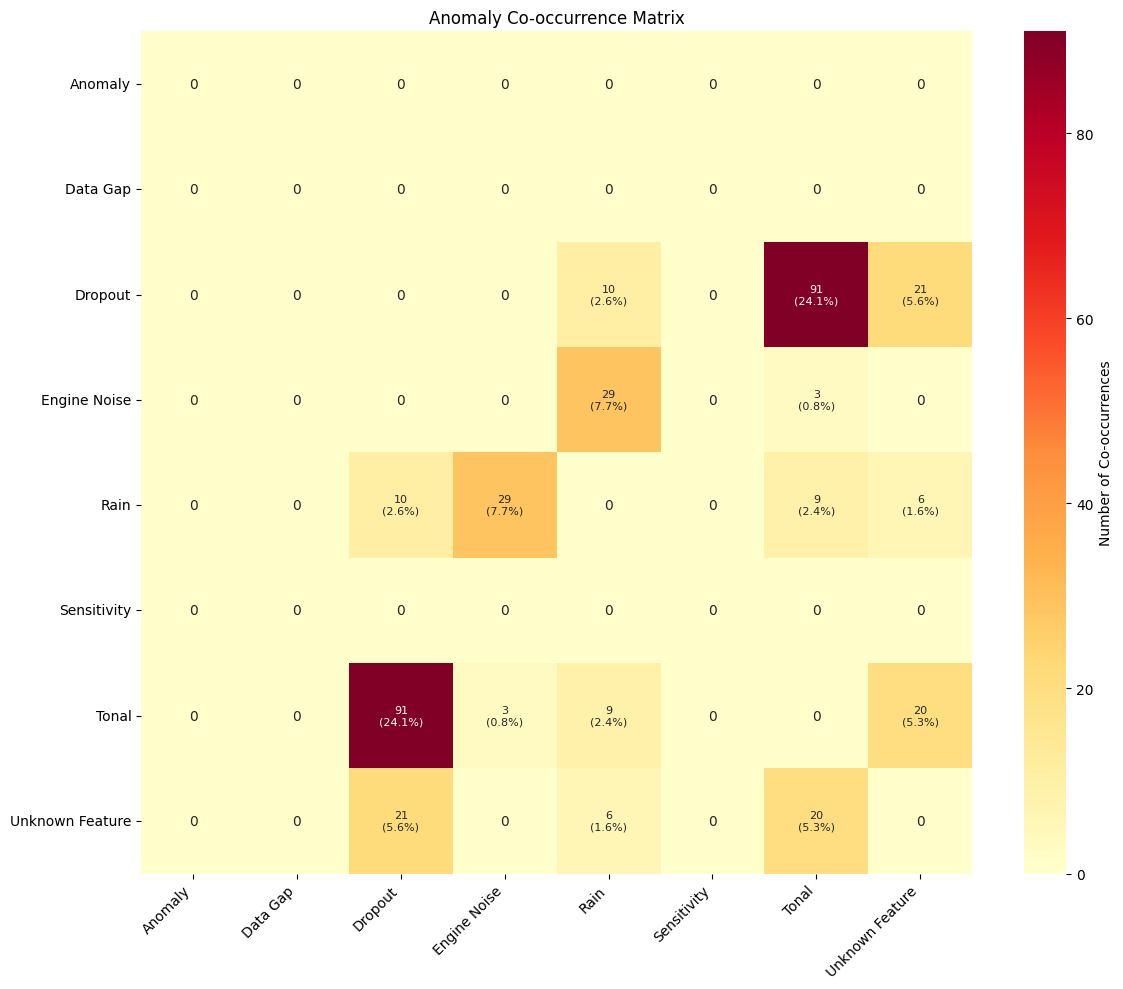

In [12]:
# Plot co-occurrence matrix
plot_co_occurrence_matrix(test_dataset)

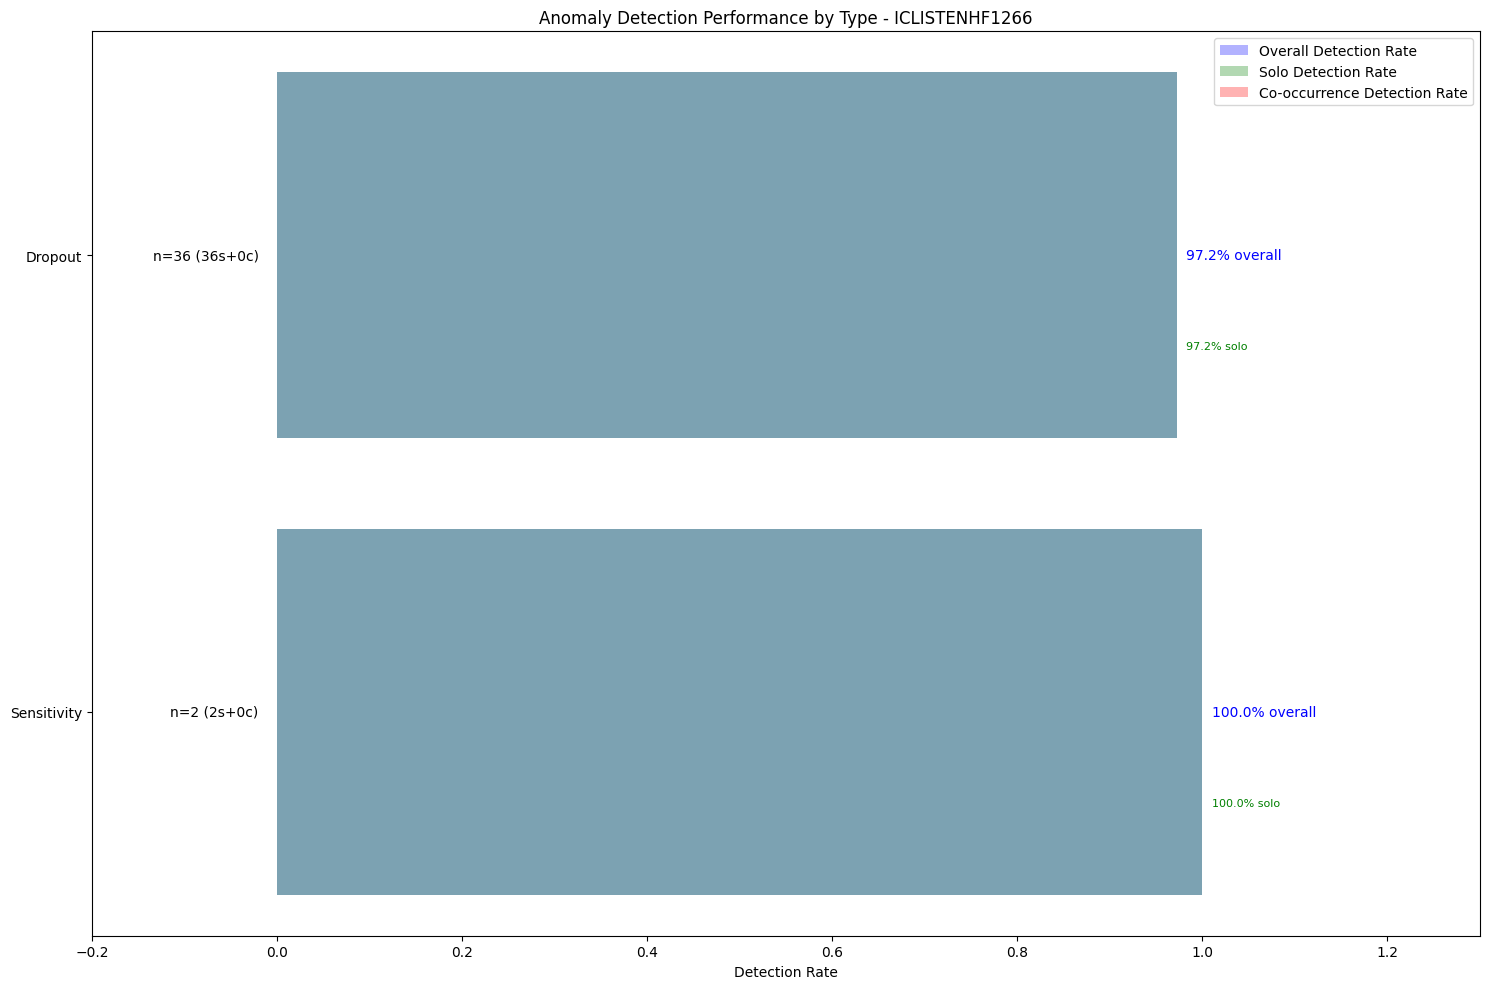

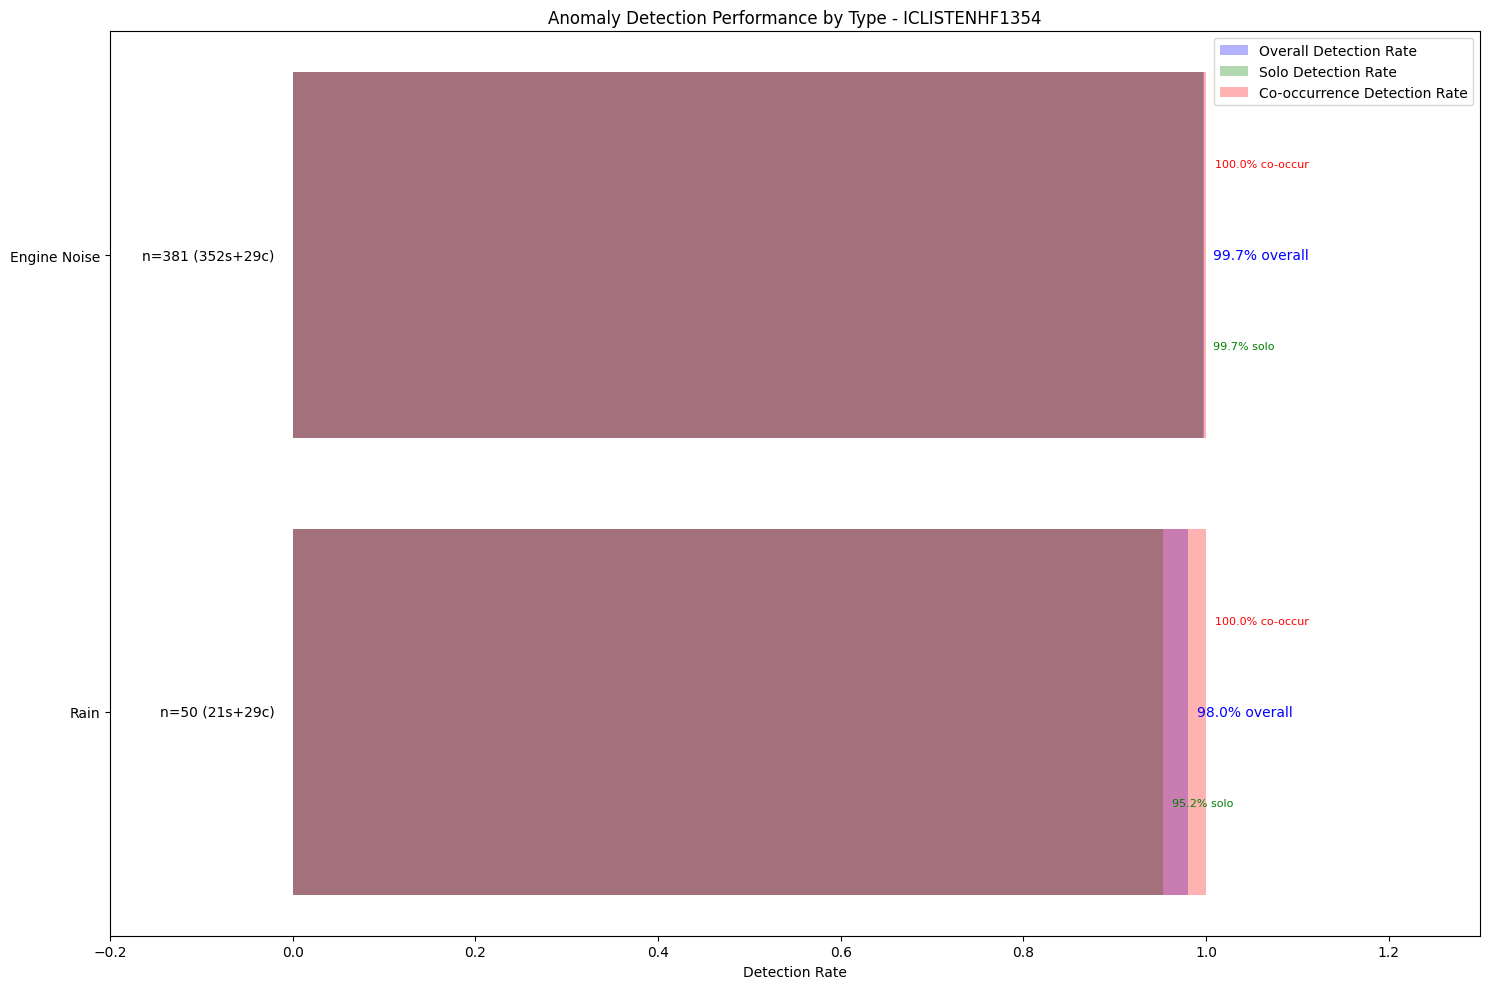

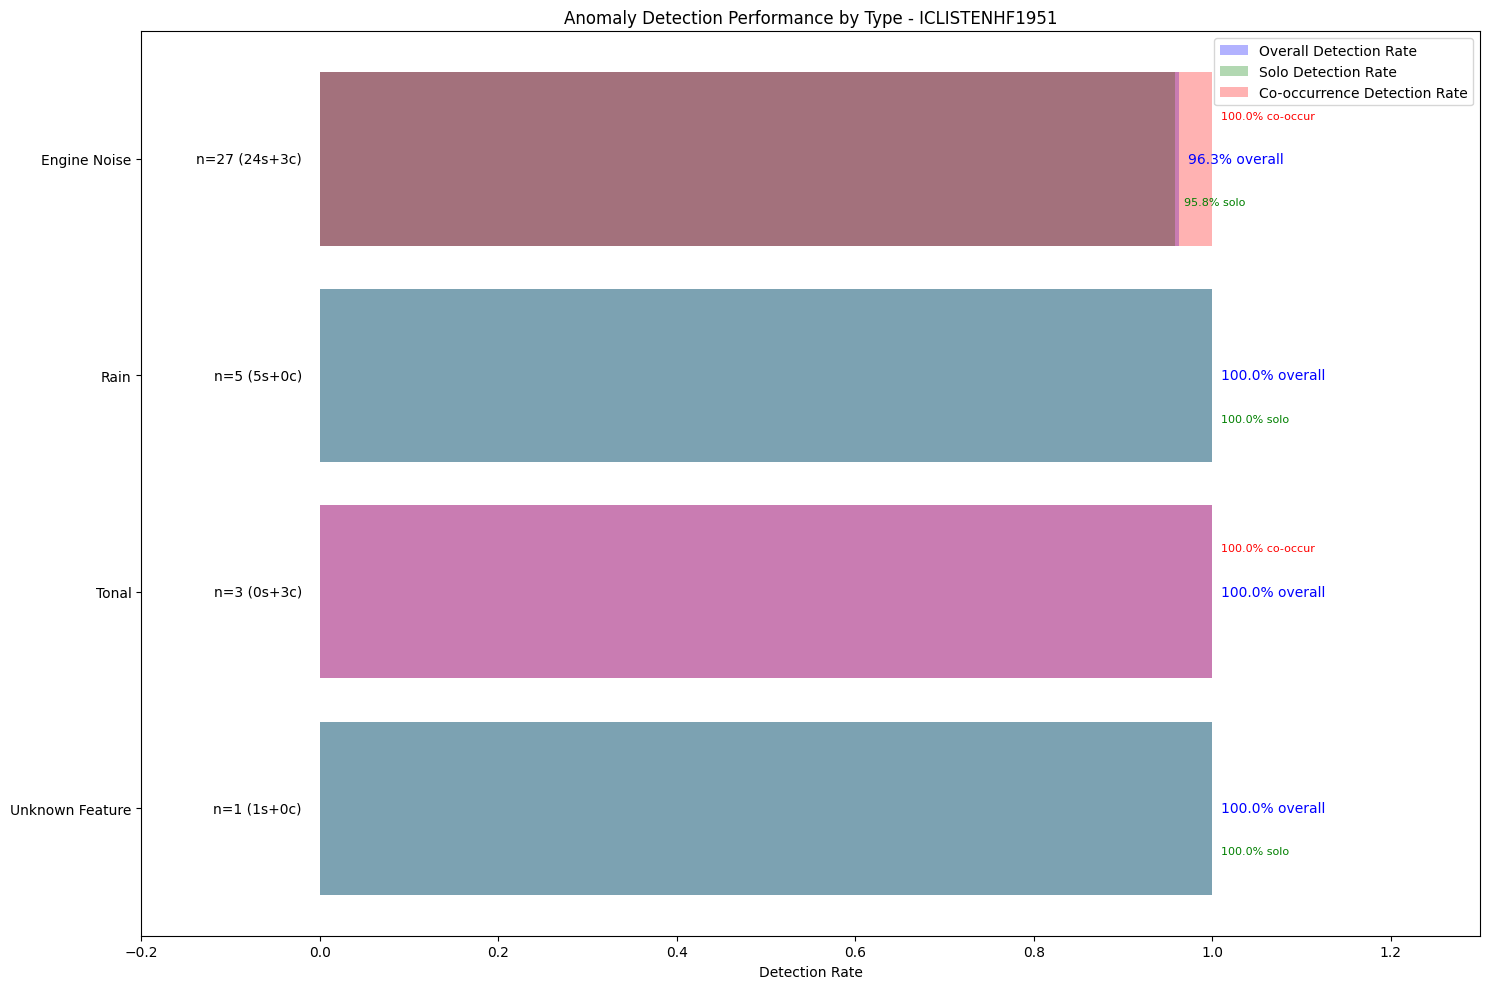

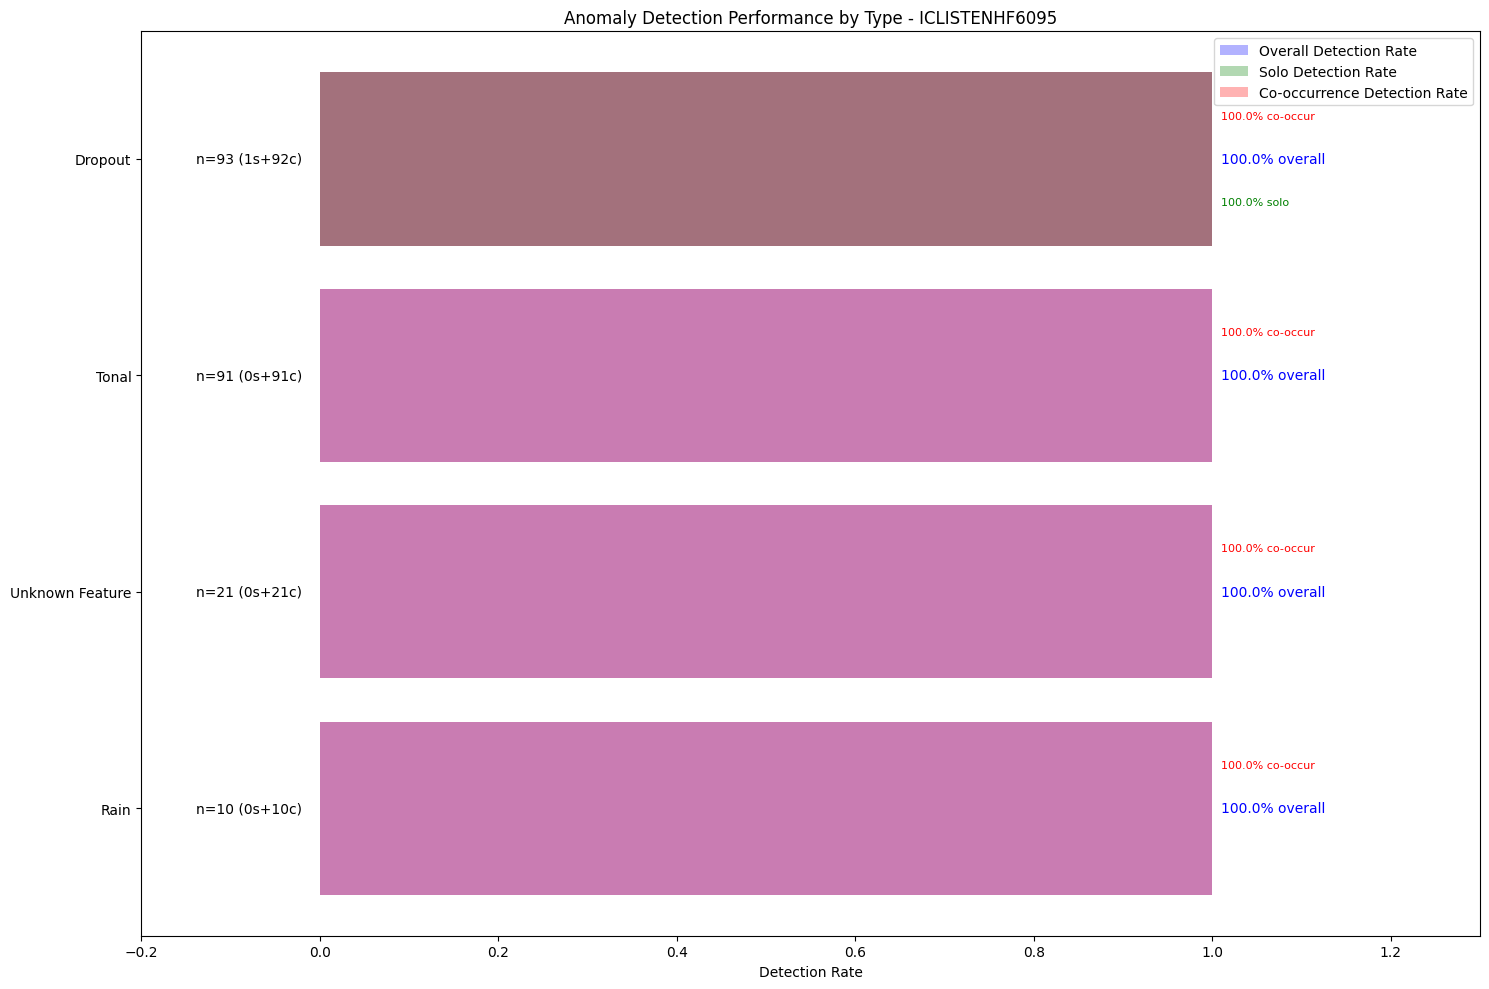

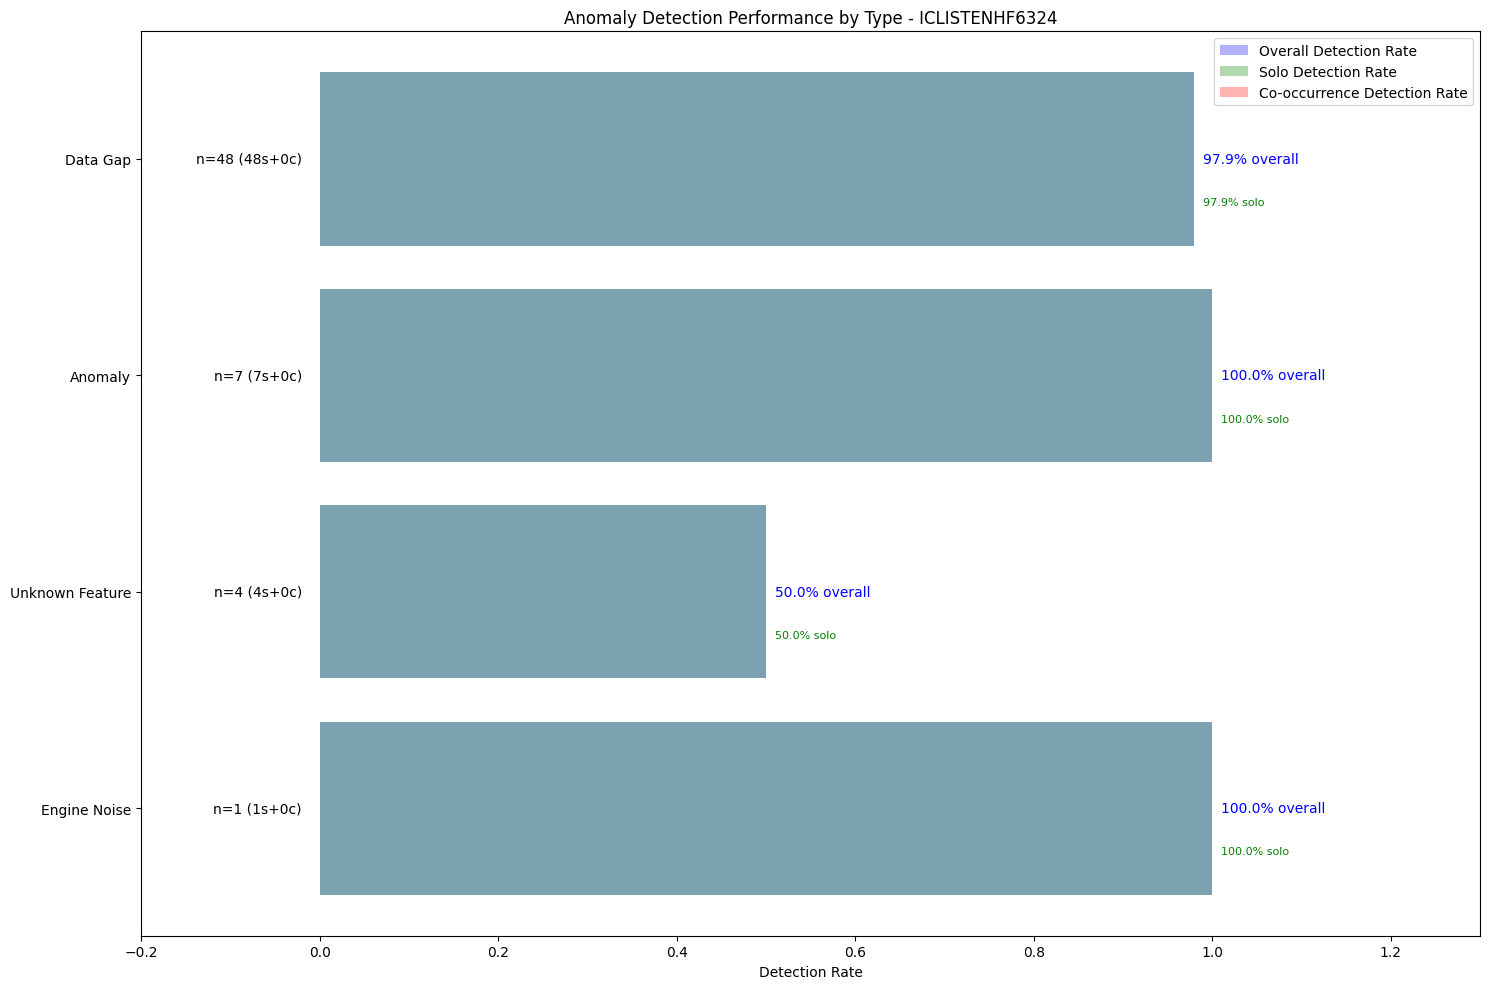

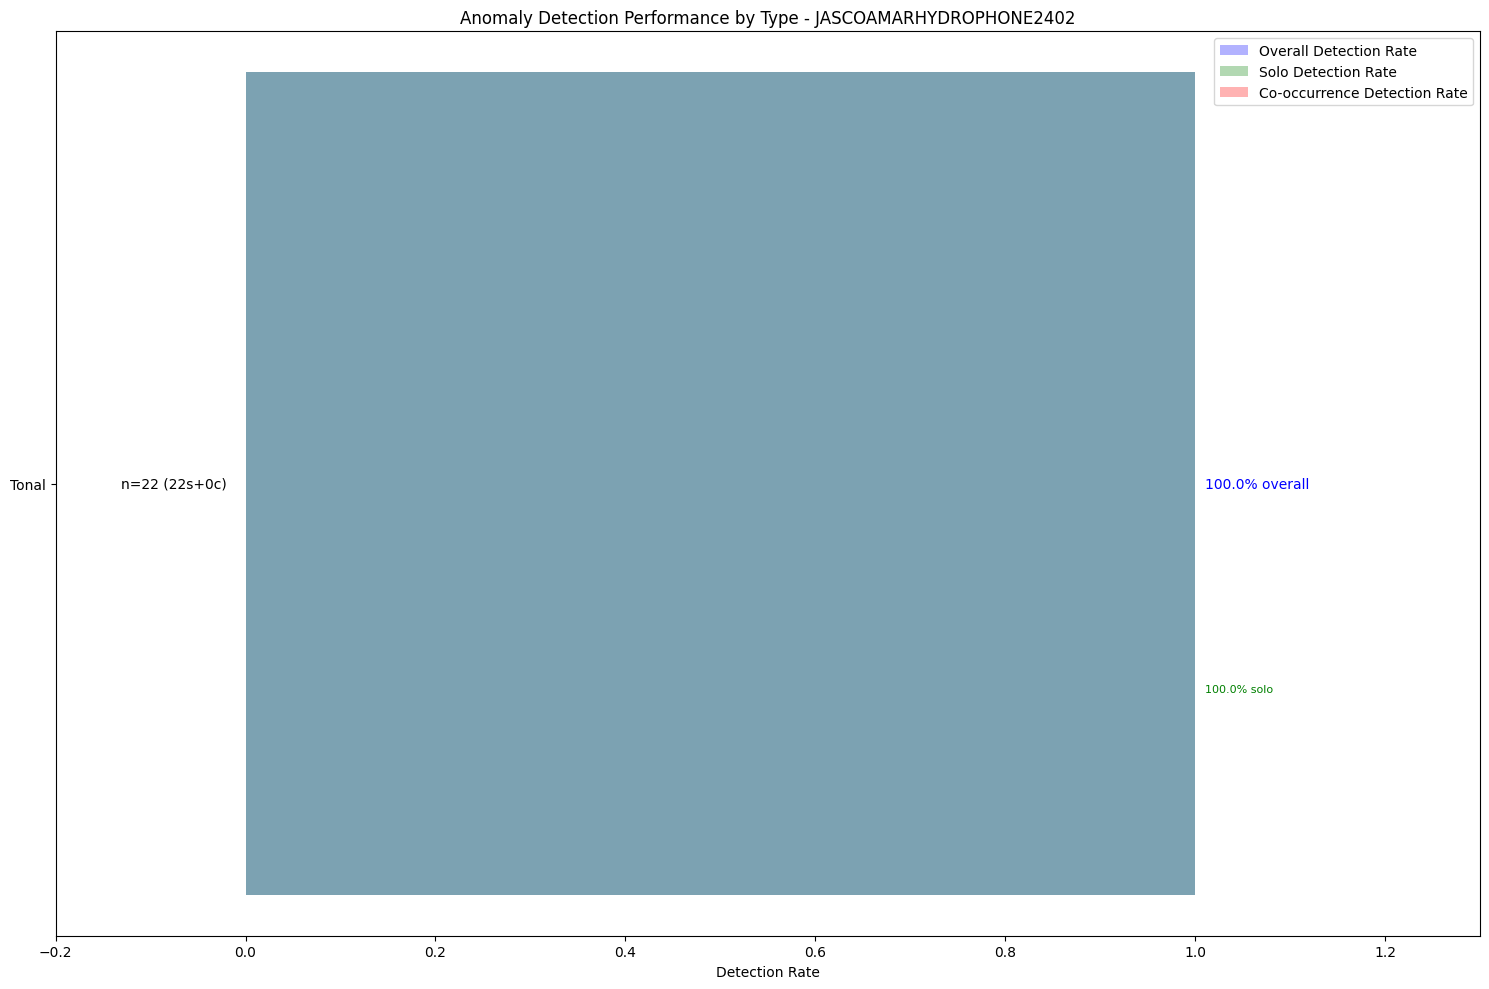

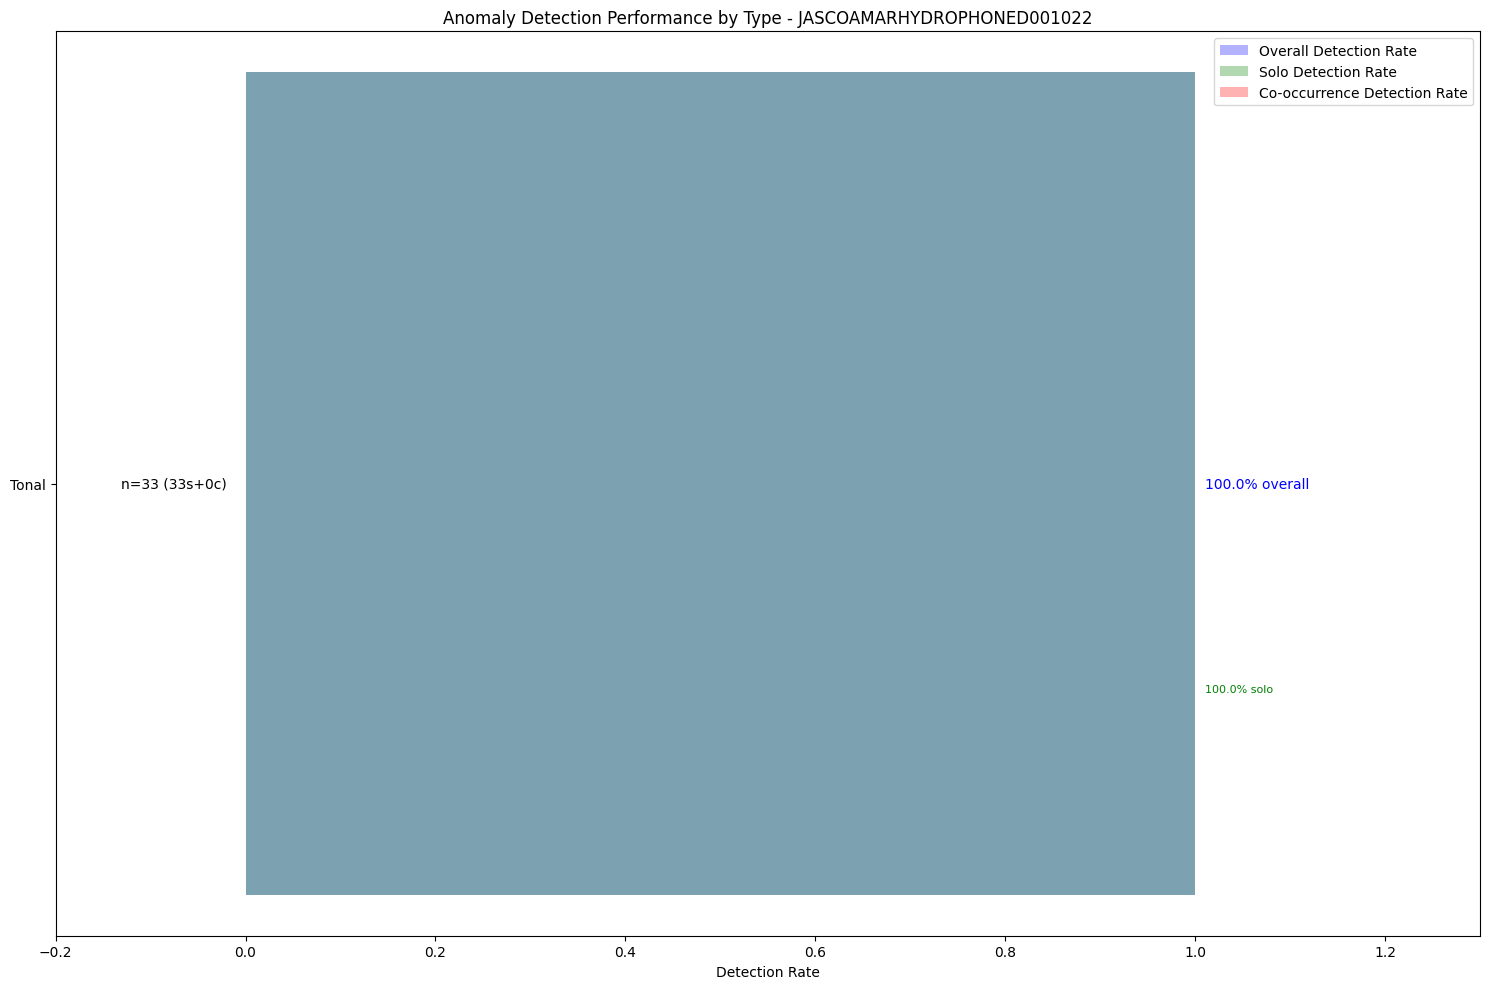

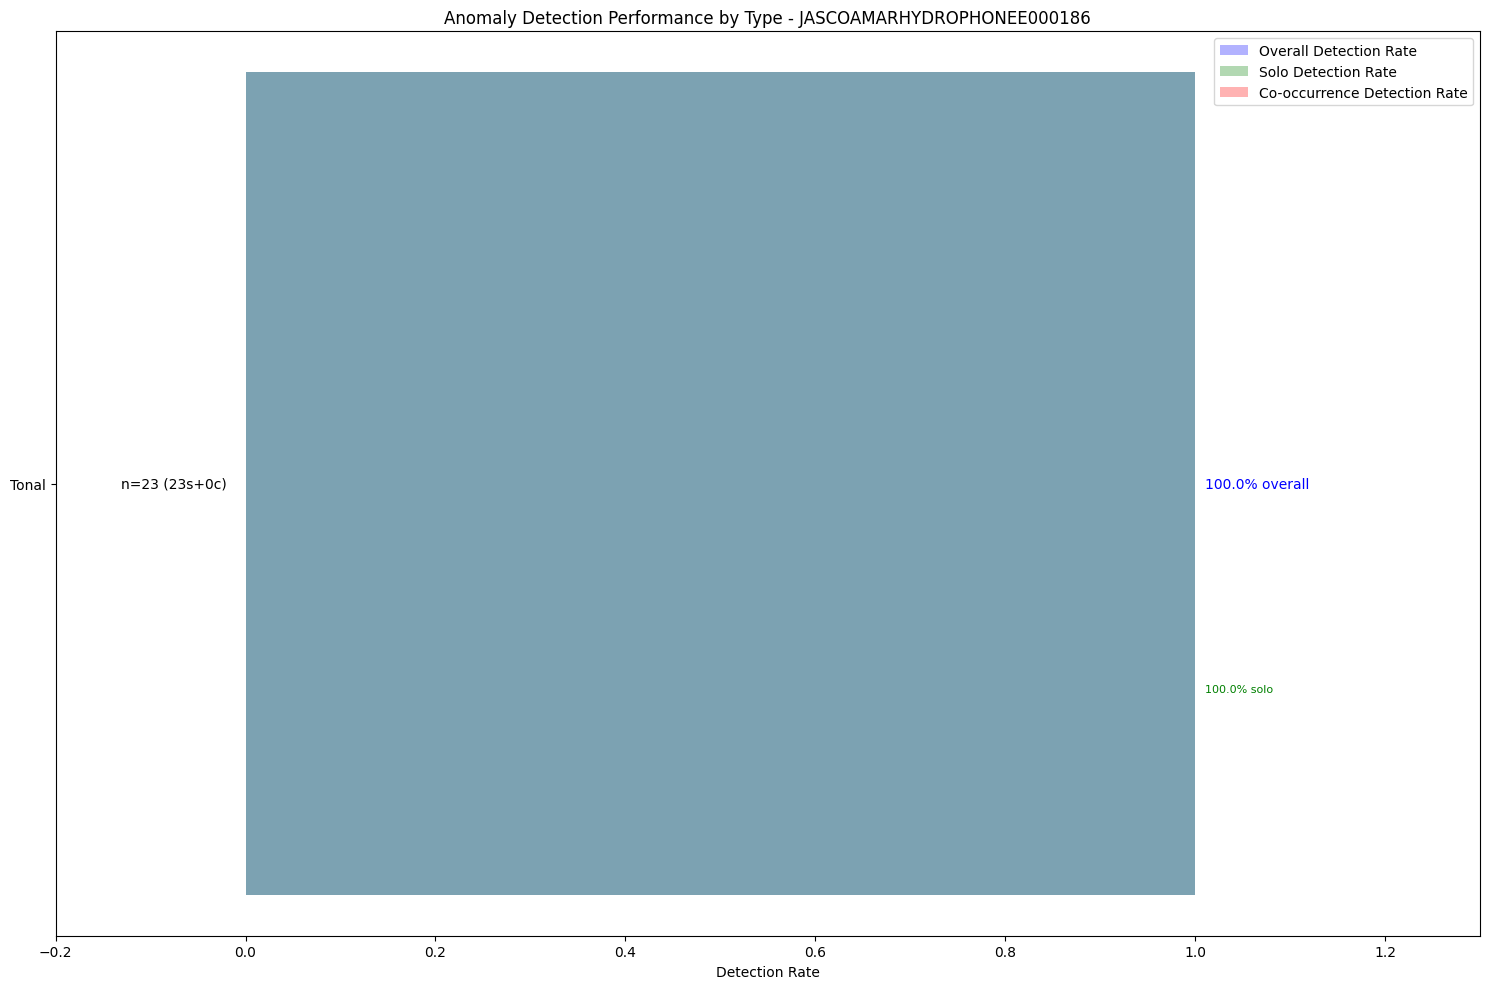

In [16]:
hydrophone_metrics = plot_anomaly_type_by_hydrophone(test_dataset, y_pred, threshold=0.5)

In [15]:
hydrophone_metrics

{'ICLISTENHF1266':   anomaly_type  total_samples  solo_occurrences  co_occurrences  \
 0      Dropout             36                36               0   
 1  Sensitivity              2                 2               0   
 
    detection_rate  solo_detection_rate  co_detection_rate  
 0        0.972222             0.972222                  0  
 1        1.000000             1.000000                  0  ,
 'ICLISTENHF1354':    anomaly_type  total_samples  solo_occurrences  co_occurrences  \
 0  Engine Noise            381               352              29   
 1          Rain             50                21              29   
 
    detection_rate  solo_detection_rate  co_detection_rate  
 0        0.997375             0.997159                1.0  
 1        0.980000             0.952381                1.0  ,
 'ICLISTENHF1951':       anomaly_type  total_samples  solo_occurrences  co_occurrences  \
 0     Engine Noise             27                24               3   
 1             Rain